## Downloading data

In [1]:
#Download Dataset
!wget 'https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz'
!tar xvzf 'rt-polaritydata.tar.gz'

--2019-12-16 18:27:36--  https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.20
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 487770 (476K) [application/x-gzip]
Saving to: ‘rt-polaritydata.tar.gz’

rt-polaritydata.tar 100%[===================>] 476.34K   280KB/s    in 1.7s    

2019-12-16 18:27:39 (280 KB/s) - ‘rt-polaritydata.tar.gz’ saved [487770/487770]

rt-polaritydata.README.1.0.txt
rt-polaritydata/rt-polarity.neg
rt-polaritydata/rt-polarity.pos


In [0]:
from google.colab import drive
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
import pandas as pd

df_neg = pd.read_csv('/content/rt-polaritydata/rt-polarity.neg', header=None, sep='±')
df_neg['polarity'] = 0

df_pos = pd.read_csv('/content/rt-polaritydata/rt-polarity.pos', header=None, sep='±')
df_pos['polarity'] = 1

df = pd.concat([df_pos, df_neg], ignore_index=True, sort=False)
df.columns = ['sentence', 'polarity']
df.head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: ParserWarning: Falling back to the 'python' engine because the separator encoded in utf-8 is > 1 char long, and the 'c' engine does not support such separators; you can avoid this warning by specifying engine='python'.
  


,sentence,polarity
0,the rock is destined to be the 21st century's ...,1
1,"the gorgeously elaborate continuation of "" the...",1
2,effective but too-tepid biopic,1
3,if you sometimes like to go to the movies to h...,1
4,"emerges as something rare , an issue movie tha...",1


## Pre-processing data (no punctuation, all words)

In [6]:
import gensim.downloader as api

glove = api.load('glove-wiki-gigaword-300')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [13]:
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
import numpy as np


# Tokenize sentences
tokenizer = Tokenizer(filters='\'!,."#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n', oov_token=True, lower=True)

tokenizer.fit_on_texts(df.sentence)
X = tokenizer.texts_to_sequences(df.sentence)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index

maxlen = max(len(x) for x in X) # longest text in train set

print('vocabubary size:',vocab_size)
print('max length text:',maxlen)

X = pad_sequences(X, padding='post', maxlen=maxlen)

embedding_dim = 300
vocab_size = len(word_index) + 1

# Prepare embedding matrix from pre-trained model
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    try:
      embedding_vector = glove[word]
      embedding_matrix[i] = embedding_vector
    except KeyError:
      continue
    except (TypeError, AttributeError):
      print(word, i)

# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(f'Ratio of words found in GloVe: {nonzero_elements / vocab_size}')

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df.polarity, test_size=0.2, random_state=42)

vocabubary size: 18398
max length text: 53
True 1
Ratio of words found in GloVe: 0.9549951081639309


## Shallow network (with non-trainable embedding layer)

In [14]:
from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate
from keras.models import load_model

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.externals import joblib

import matplotlib.pyplot as plt

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model.add(Conv1D(512, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

# Fit model
history = model.fit(X_train, y_train,
                    epochs=20,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)









Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 53, 300)           5519400   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 51, 512)           461312    
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________

In [0]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

8529/8529 [==============================] - 1s 102us/step
Training Accuracy: 0.9981
Testing Accuracy:  0.7534


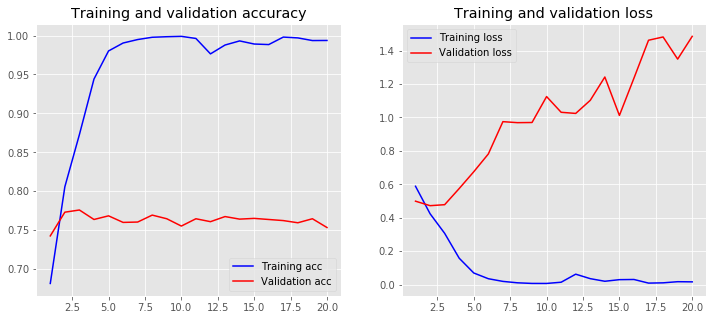

In [0]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Shallow network (with trainable embedding layer)

In [20]:
from keras import layers
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout, Flatten, MaxPooling1D, Input, Concatenate
from keras.models import load_model

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.externals import joblib

import matplotlib.pyplot as plt

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=True))
model.add(Conv1D(512, 3, activation='relu'))
model.add(GlobalMaxPooling1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

# Fit model
history = model.fit(X_train, y_train,
                    epochs=3,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 53, 300)           5519400   
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 51, 512)           461312    
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 512)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               65664     
_________________________________________________________________
dropout_5 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)                 129       
Total params: 6,046,505
Trainable params: 6,046,505
Non-trainable params: 0
____________________________________________

8529/8529 [==============================] - 1s 103us/step
Training Accuracy: 0.9893
Testing Accuracy:  0.7740


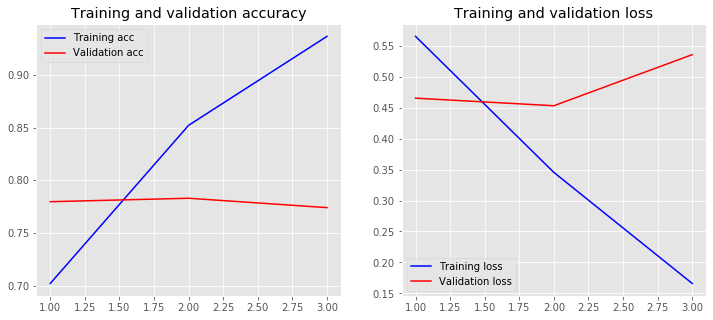

In [0]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Deeper CNN (non-trainable embeddings)


In [19]:
# Deep CNN
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=False))
model.add(Conv1D(128, 7, activation='relu',padding='same'))
model.add(MaxPooling1D())
model.add(Conv1D(256, 5, activation='relu',padding='same'))
model.add(MaxPooling1D())
model.add(Conv1D(512, 3, activation='relu',padding='same'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

# Fit model
history = model.fit(X_train, y_train,
                    epochs=3,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 53, 300)           5519400   
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 53, 128)           268928    
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 26, 128)           0         
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 26, 256)           164096    
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 13, 256)           0         
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 13, 512)           393728    
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 6, 512)           

8529/8529 [==============================] - 1s 130us/step
Training Accuracy: 0.9451
Testing Accuracy:  0.7707


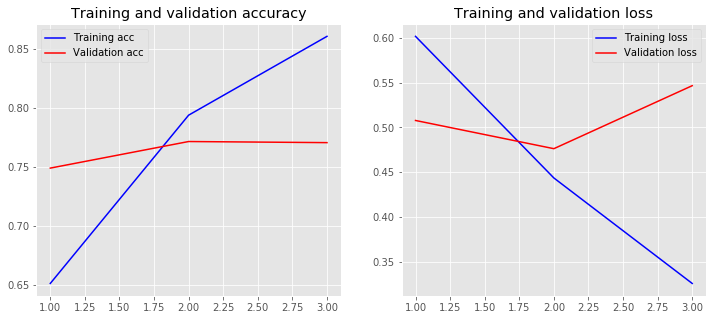

In [0]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Deeper CNN (training word-embeddings)

In [21]:
# Deep CNN
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=True))
model.add(Conv1D(128, 7, activation='relu',padding='same'))
model.add(MaxPooling1D())
model.add(Conv1D(256, 5, activation='relu',padding='same'))
model.add(MaxPooling1D())
model.add(Conv1D(512, 3, activation='relu',padding='same'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

# Fit model
history = model.fit(X_train, y_train,
                    epochs=3,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 53, 300)           5519400   
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 53, 128)           268928    
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 26, 128)           0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 26, 256)           164096    
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 13, 256)           0         
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 13, 512)           393728    
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 6, 512)           

8529/8529 [==============================] - 1s 158us/step
Training Accuracy: 0.9882
Testing Accuracy:  0.7773


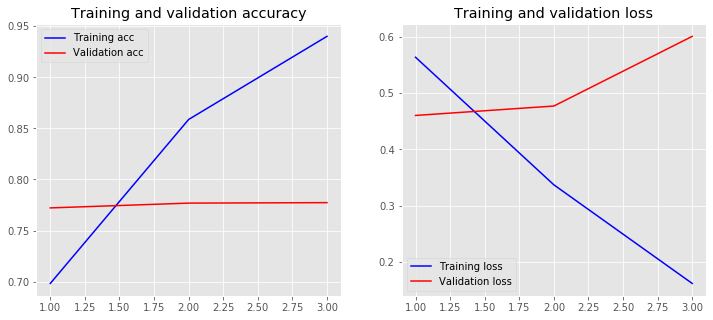

In [0]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Kim-Soon CNN (non-trainable word-embeddings)

In [0]:
from keras.models import Model
from keras.layers import Input, Dense

sequence_input = Input(shape=(maxlen,), dtype='int32')

embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

for fsz in filter_sizes:
    x = Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = MaxPooling1D()(x)
    convs.append(x)
    
x = Concatenate(axis=-1)(convs)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, output)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

# Fit model
history = model.fit(X_train, y_train,
                    epochs=3,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)

Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            (None, 59)           0                                            
__________________________________________________________________________________________________
embedding_27 (Embedding)        (None, 59, 300)      5520000     input_8[0][0]                    
__________________________________________________________________________________________________
conv1d_63 (Conv1D)              (None, 59, 128)      115328      embedding_27[0][0]               
__________________________________________________________________________________________________
conv1d_64 (Conv1D)              (None, 59, 128)      153728      embedding_27[0][0]               
____________________________________________________________________________________________

In [0]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

## Pre-processing data (no punctuation, 14,000 most frequent words)

In [0]:
import gensim.downloader as api

glove = api.load('glove-wiki-gigaword-300')

/usr/local/lib/python3.6/dist-packages/smart_open/smart_open_lib.py:402: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [15]:
from keras.preprocessing.text import Tokenizer, one_hot
from keras.preprocessing.sequence import pad_sequences
import numpy as np


# Tokenize sentences
tokenizer = Tokenizer(filters='\'!,."#$%&()*+-/:;<=>@[\\]^_`{|}~\t\n', oov_token=True, lower=True, num_words=14000)

tokenizer.fit_on_texts(df.sentence)
X = tokenizer.texts_to_sequences(df.sentence)

word_index = tokenizer.word_index
vocab_size = len(word_index) + 1  # Adding 1 because of reserved 0 index

maxlen = max(len(x) for x in X) # longest text in train set

print('vocabubary size:',vocab_size)
print('max length text:',maxlen)

X = pad_sequences(X, padding='post', maxlen=maxlen)

embedding_dim = 300
vocab_size = len(word_index) + 1

# Prepare embedding matrix from pre-trained model
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    try:
      embedding_vector = glove[word]
      embedding_matrix[i] = embedding_vector
    except KeyError:
      continue
    except (TypeError, AttributeError):
      print(word, i)

# Check % words with embeddings 
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
print(f'Ratio of words found in GloVe: {nonzero_elements / vocab_size}')

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, df.polarity, test_size=0.2, random_state=42)

vocabubary size: 18398
max length text: 53
True 1
Ratio of words found in GloVe: 0.9549951081639309


## Kim-Soon CNN (non-trainable word-embeddings)

In [16]:
from keras.models import Model
from keras.layers import Input, Dense

sequence_input = Input(shape=(maxlen,), dtype='int32')

embedding_layer = Embedding(vocab_size,
                            embedding_dim,
                            weights=[embedding_matrix],
                            input_length=maxlen,
                            trainable=True)

embedded_sequences = embedding_layer(sequence_input)

convs = []
filter_sizes = [3,4,5]

for fsz in filter_sizes:
    x = Conv1D(128, fsz, activation='relu',padding='same')(embedded_sequences)
    x = MaxPooling1D()(x)
    convs.append(x)
    
x = Concatenate(axis=-1)(convs)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(sequence_input, output)
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

# Fit model
history = model.fit(X_train, y_train,
                    epochs=4,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 53)           0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 53, 300)      5519400     input_2[0][0]                    
__________________________________________________________________________________________________
conv1d_2 (Conv1D)               (None, 53, 128)      115328      embedding_2[0][0]                
__________________________________________________________________________________________________
conv1d_3 (Conv1D)               (None, 53, 128)      153728      embedding_2[0][0]                
___________________________________________________________________________________________

In [17]:
loss, accuracy = model.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

8529/8529 [==============================] - 1s 82us/step
Training Accuracy: 0.9967
Testing Accuracy:  0.8350


NameError: ignored

## Analyzing results

Let's use our best-performing model

In [0]:
# Deep CNN
model = Sequential()
model.add(Embedding(vocab_size, embedding_dim, input_length=maxlen,weights=[embedding_matrix],trainable=True))
model.add(Conv1D(128, 7, activation='relu',padding='same'))
model.add(MaxPooling1D())
model.add(Conv1D(256, 5, activation='relu',padding='same'))
model.add(MaxPooling1D())
model.add(Conv1D(512, 3, activation='relu',padding='same'))
model.add(MaxPooling1D())
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()

# Fit model
history = model.fit(X_train, y_train,
                    epochs=3,
                    verbose=True,
                    validation_data=(X_test, y_test),
                    batch_size=64)

Model: "sequential_22"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_30 (Embedding)     (None, 59, 300)           5520000   
_________________________________________________________________
conv1d_68 (Conv1D)           (None, 59, 128)           268928    
_________________________________________________________________
max_pooling1d_58 (MaxPooling (None, 29, 128)           0         
_________________________________________________________________
conv1d_69 (Conv1D)           (None, 29, 256)           164096    
_________________________________________________________________
max_pooling1d_59 (MaxPooling (None, 14, 256)           0         
_________________________________________________________________
conv1d_70 (Conv1D)           (None, 14, 512)           393728    
_________________________________________________________________
max_pooling1d_60 (MaxPooling (None, 7, 512)          

In [0]:
preds = model.predict(X_test)
preds = np.rint(preds).reshape((-1,))

incorrects = preds != y_test # indices of incorrect predictions

incorrect_sents = X_test[incorrects]
incorrect_preds = preds[incorrects]
incorrect_y = y_test[incorrects]

def to_text(sequence):
  trimmed = np.trim_zeros(sequence)
  sentence = tokenizer.sequences_to_texts(np.array([trimmed]))

  return ' '.join(sentence)

LIMIT = 10
for sequence, pred, actual in list(zip(incorrect_sents, incorrect_preds, incorrect_y))[:LIMIT]:
  sentence = to_text(sequence)
  print(f"Sentence:\n{sentence}\nPrediction: {pred}, actual: {actual}\n")

Sentence:
director chris eyre is going through the paces again with his usual high melodramatic style of filmmaking .
Prediction: 1.0, actual: 0

Sentence:
although it lacks the detail of the book , the film does pack some serious suspense .
Prediction: 0.0, actual: 1

Sentence:
the message of such reflections intentional or not is that while no art grows from a vacuum , many artists exist in one .
Prediction: 0.0, actual: 1

Sentence:
a depressing confirmation of everything those of us who don t object to the description unelected have suspected all along george w . bush is an incurious , uncharismatic , overgrown frat boy with a mean streak a mile wide .
Prediction: 0.0, actual: 1

Sentence:
does paint some memorable images . . . , but makhmalbaf keeps her distance from the characters
Prediction: 1.0, actual: 0

Sentence:
only two words will tell you what you know when deciding to see it anthony . hopkins .
Prediction: 0.0, actual: 1

Sentence:
4 friends , 2 couples , 2000 miles , an